In [1]:
import pandas as pd
import os
import librosa
import librosa.display
import IPython.display as ipd
import numpy as np
import scipy
import seaborn

import re

#Data handling
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import Perceptron, SGDClassifier
from sklearn.tree import DecisionTreeClassifier
#Normalizer
from sklearn.preprocessing import MinMaxScaler

from six.moves import cPickle as pickle

import matplotlib.pyplot as plt
import matplotlib.style as ms
ms.use('seaborn-muted')
%matplotlib inline

x_train = []
y_train = []
x_test = []
y_test = []

In [2]:
def get_gender(text):
    text = text[len(text)-4]
    if('F' in text):
        return 'F'
    elif('M' in text):
        return 'M'
    else:
        return 'N/A'
    
def get_word_segments(align_file):
    segments = []
    with open(align_file,'r') as openFile:
        read_lines = openFile.readlines()
        lines = read_lines[1:len(read_lines)-1]
        for line in lines:
            splitted = line.split()
            segments.append({'sf': splitted[0], 'ef':splitted[1],'seg_scr':splitted[2],'word':splitted[3]})
    return segments
    
def generate_IEMOCAP_df():
    root_path = 'data/IEMOCAP_full_release/'
    folders = os.listdir(root_path)
    session_folders = filter(lambda x: x.startswith('Session'),folders)
    sentences_wav = '/sentences/wav/'
    forced_alignment = '/sentences/ForcedAlignment/'
    dialog_transcriptions = '/dialog/transcriptions/' #Ses01F_impro01.txt
    dialog_emo = '/dialog/EmoEvaluation/' #Ses01F_impro01.txt
    data = {}
    emotions = {}
    alignment = {}
    for session in session_folders:
        temp_root = root_path + session
        temp_conversations_path = temp_root + sentences_wav
        temp_transcripts_path = temp_root + dialog_transcriptions
        temp_alignments_path = temp_root + forced_alignment
        temp_emo_path = temp_root + dialog_emo
        emo_eval = os.listdir(temp_emo_path)
        for emo_file in emo_eval:
            emo_file_path = temp_emo_path + emo_file
            if(emo_file.endswith('.txt')):
                with open(emo_file_path,'r') as openFile:
                    for line in openFile.readlines():
                        if(line.startswith('[')):
                            line = line.split()
                            key = line[3]
                            emotion = line[4]
                            valence = re.search('[0-9]+.[0-9]+', line[5]).group(0)
                            arousal = re.search('[0-9]+.[0-9]+',line[6]).group(0)
                            dominance = re.search('[0-9]+.[0-9]+',line[7]).group(0)
                            emotions[key] = [emotion,valence,arousal, dominance]
        transcriptions = os.listdir(temp_transcripts_path)
        for transcript in transcriptions:
            transcript_path = temp_transcripts_path + transcript
            with open(transcript_path,'r') as openFile:
                for line in openFile.readlines():
                    if(line.startswith('Ses')):
                        line = line.split(' [')
                        key = line[0]
                        if('XX' not in key):
                            line = ' ['.join(line[1:])
                            line = line.split(']: ')
                            time = line[0]
                            script = ']: '.join(line[1:])
                            start_t, end_t = time.split('-')
                            data[key] = [start_t,end_t,script.split('\r\n')[0]]
        conversations = os.listdir(temp_conversations_path)
        for conversation in conversations:
            files_path = temp_conversations_path+ conversation
            alignments_path = temp_alignments_path + conversation
            files = os.listdir(files_path)
            for file in files:
                key,suf = file.split('.')
                if(suf == 'wav'):
                    data[key].append(files_path + '/'+ file)
                    data[key].append(alignments_path + '/'+key+'.wdseg')
    sentence_df = pd.DataFrame(data,index=['start_time','end_time','text','wav_path','alignment_path']).T
    emotion_df = pd.DataFrame(emotions, index=['emotion','valence','arousal','dominance']).T
    full = sentence_df.join(emotion_df)
    full = full.reset_index()
    full['gender'] = full['index'].apply(get_gender)
    return full

# Models

In [3]:
def log_reg(x_train,y_train,x_test,y_test, delete = True):
    logreg = LogisticRegression()
    logreg.fit(x_train, y_train)
    Y_pred = logreg.predict(x_test)
    acc_log = round(logreg.score(x_test, y_test) * 100, 2)
    if(delete):
        del logreg
        return Y_pred, acc_log
    return logreg,Y_pred,acc_log

# _, acc_log = log_reg(x_train,ang_train, x_test, ang_test)
# print(acc_log)

def svc(x_train,y_train,x_test,y_test, delete = True):
    svc = SVC()
    svc.fit(x_train,y_train)
    Y_svcpred = svc.predict(x_test)
    acc_svc = round(svc.score(x_test, y_test) * 100,2)
    if(delete):
        del svc 
        return Y_svcpred, acc_svc
    return svc, Y_svcpred, acc_svc

# _, acc_svc = svc(x_train,ang_train,x_test,ang_test)
# print(acc_svc)

def knn(x_train,y_train,x_test,y_test,n_neighbors = 3,delete = True):
    knn = KNeighborsClassifier(n_neighbors = n_neighbors)
    knn.fit(x_train, y_train)
    Y_knnpred = knn.predict(x_test)
    acc_knn = round(knn.score(x_test, y_test) * 100, 2)
    if(delete):
        del knn
        return Y_knnpred, acc_knn
    return knn, Y_knnpred, acc_knn    
# _,acc_knn = knn(x_train,ang_train,x_test,ang_test)
# print(acc_knn)

def gaussian(x_train,y_train,x_test,y_test,delete = True):
    gaussian = GaussianNB()
    gaussian.fit(x_train, y_train)
    Y_gaussianpred = gaussian.predict(x_test)
    acc_gaussian = round(gaussian.score(x_test, y_test) * 100, 2)
    if(delete):
        del gaussian
        return Y_gaussianpred, acc_gaussian
    return gaussian, Y_gaussianpred, acc_gaussian

# _, acc_gaussian = gaussian(x_train,ang_train,x_test,ang_test)
# print(acc_gaussian)

def perceptron(x_train,y_train,x_test,y_test,delete = True):
    perceptron = Perceptron()
    perceptron.fit(x_train, y_train)
    Y_perceptronpred = perceptron.predict(x_test)
    acc_perceptron = round(perceptron.score(x_test, y_test) * 100, 2)
    if(delete):
        del perceptron
        return Y_perceptronpred, acc_perceptron
    return perceptron, Y_perceptronpred ,acc_perceptron
# _, acc_perceptron = perceptron(x_train,ang_train,x_test,ang_test)
# print(acc_perceptron)

def linear_svc(x_train,y_train,x_test,y_test,delete = True):
    linear_svc = LinearSVC()
    linear_svc.fit(x_train, y_train)
    Y_linearsvcpred = linear_svc.predict(x_test)
    acc_linear_svc = round(linear_svc.score(x_test, y_test) * 100, 2)
    if(delete):
        del linear_svc
        return Y_linearsvcpred, acc_linear_svc
    return linear_svc, Y_linearsvcpred, acc_linear_svc
# _, acc_linear_svc = linear_svc(x_train,ang_train,x_test,ang_test)
# print(acc_linear_svc)

def sgd(x_train,y_train,x_test,y_test,delete = True):
    sgd = SGDClassifier()
    sgd.fit(x_train, y_train)
    Y_linearsgdpred = sgd.predict(x_test)
    acc_sgd = round(sgd.score(x_test, y_test) * 100, 2)
    if(delete):
        del sgd
        return Y_linearsgdpred , acc_sgd
    return sgd, Y_linearsgdpred, acc_sgd
# _, acc_sgd = sgd(x_train,ang_train,x_test,ang_test)
# print(acc_sgd)

def decision_tree(x_train,y_train,x_test,y_test,delete = True):
    decision_tree = DecisionTreeClassifier()
    decision_tree.fit(x_train, y_train)
    Y_dectreepred = decision_tree.predict(x_test)
    acc_decision_tree = round(decision_tree.score(x_test, y_test) * 100, 2)
    if(delete):
        del decision_tree
        return Y_dectreepred , acc_decision_tree
    return decision_tree, Y_dectreepred , acc_decision_tree
# _, acc_decision_tree = decision_tree(x_train,ang_train,x_test,ang_test)
# print(acc_decision_tree)

def random_forest(x_train,y_train,x_test,y_test,n_estimators = 100, delete = True):
    random_forest = RandomForestClassifier(n_estimators= n_estimators)
    random_forest.fit(x_train, y_train)
    Y_pred = random_forest.predict(x_test)
    acc_random_forest = round(random_forest.score(x_test, y_test) * 100, 2)
    if(delete):
        del random_forest
        return Y_pred, acc_random_forest
    return random_forest, Y_pred, acc_random_forest
# _, acc_random_forest = random_forest(x_train,ang_train, x_test , ang_test)
# print(acc_random_forest)

def compare_models(x_train, y_train, x_test, y_test):
    _,acc_svc = svc(x_train,y_train,x_test,y_test)
    _,acc_knn = knn(x_train,y_train,x_test,y_test)
    _,acc_log = log_reg(x_train,y_train,x_test,y_test)
    _,acc_random_forest = random_forest(x_train,y_train,x_test,y_test)
    _,acc_gaussian = gaussian(x_train,y_train,x_test,y_test)
    _,acc_perceptron = perceptron(x_train,y_train,x_test,y_test)
    _,acc_sgd = sgd(x_train,y_train,x_test,y_test)
    _,acc_linear_svc = linear_svc(x_train,y_train,x_test,y_test)
    _,acc_decision_tree =  decision_tree(x_train,y_train,x_test,y_test)
    models = pd.DataFrame({
        'Model': ['Support Vector Machines', 'KNN', 'Logistic Regression', 
                  'Random Forest', 'Naive Bayes', 'Perceptron', 
                  'Stochastic Gradient Decent', 'Linear SVC', 
                  'Decision Tree'],
        'Score': [acc_svc, acc_knn, acc_log, 
                  acc_random_forest, acc_gaussian, acc_perceptron, 
                  acc_sgd, acc_linear_svc, acc_decision_tree]})
    return models #.sort_values(by='Score', ascending=False)

def compare_models_x_emotions(x_train, x_test, emotions):
    result = {'Model': ['Support Vector Machines', 'KNN', 'Logistic Regression', 
                  'Random Forest', 'Naive Bayes', 'Perceptron', 
                  'Stochastic Gradient Decent', 'Linear SVC', 
                  'Decision Tree']}
    for emotion,data in emotions.iteritems():
        y_train = data[0]
        y_test = data[1]
        _,acc_svc = svc(x_train,y_train,x_test,y_test)
        _,acc_knn = knn(x_train,y_train,x_test,y_test)
        _,acc_log = log_reg(x_train,y_train,x_test,y_test)
        _,acc_random_forest = random_forest(x_train,y_train,x_test,y_test)
        _,acc_gaussian = gaussian(x_train,y_train,x_test,y_test)
        _,acc_perceptron = perceptron(x_train,y_train,x_test,y_test)
        _,acc_sgd = sgd(x_train,y_train,x_test,y_test)
        _,acc_linear_svc = linear_svc(x_train,y_train,x_test,y_test)
        _,acc_decision_tree =  decision_tree(x_train,y_train,x_test,y_test)
        result[emotion] = [acc_svc, acc_knn, acc_log, 
                  acc_random_forest, acc_gaussian, acc_perceptron, 
                  acc_sgd, acc_linear_svc, acc_decision_tree]
    models = pd.DataFrame(result)
    models = models[['Model'] + list(emotions.iterkeys())]
    return models
        
    



In [4]:
# full = generate_IEMOCAP_df()
data = pd.read_csv('data/IEMOCAP_sentences.csv',index_col=0)
data.head(3)


index  start_time  end_time                 text  \
0  Ses01F_impro01_F000      6.2901    8.2357           Excuse me.   
1  Ses01F_impro01_F001     10.0100   11.3925                Yeah.   
2  Ses01F_impro01_F002     14.8872   18.0175  Is there a problem?   

                                            wav_path  \
0  data/IEMOCAP_full_release/Session1/sentences/w...   
1  data/IEMOCAP_full_release/Session1/sentences/w...   
2  data/IEMOCAP_full_release/Session1/sentences/w...   

                                      alignment_path emotion  valence  \
0  data/IEMOCAP_full_release/Session1/sentences/F...     neu      2.5   
1  data/IEMOCAP_full_release/Session1/sentences/F...     neu      2.5   
2  data/IEMOCAP_full_release/Session1/sentences/F...     neu      2.5   

   arousal  dominance gender  
0      2.5        2.5      F  
1      2.5        2.5      F  
2      2.5        2.5      F

In [5]:
# full.to_csv('data/IEMOCAP_sentences.csv')

data = data[(data.emotion != 'oth')&(data.emotion != 'xxx')]
data.groupby('emotion').count()

index  start_time  end_time  text  wav_path  alignment_path  valence  \
emotion                                                                         
ang       1103        1103      1103  1103      1103            1103     1103   
dis          2           2         2     2         2               2        2   
exc       1041        1041      1041  1041      1041            1041     1041   
fea         40          40        40    40        40              40       40   
fru       1849        1849      1849  1849      1849            1849     1849   
hap        595         595       595   595       595             595      595   
neu       1708        1708      1708  1708      1708            1708     1708   
sad       1084        1084      1084  1084      1084            1084     1084   
sur        107         107       107   107       107             107      107   

         arousal  dominance  gender  
emotion                              
ang         1103       1103    1103  
dis            2          2       2  
exc         1041       1041    1041  
fea           40         40      40  
fru         1849       1849    1849  
hap          595        595     595  
neu         1708       1708    1708  
sad         1084       1084    1084  
sur          107        107     107

In [6]:
emotional_mapping = {'ang': 0, 'sad': 1, 'exc': 2, 'neu': 3,'fru': 4,'hap': 5,'fea': 6,'sur': 7,'dis': 8, 'xxx':9,'oth':10}
data['emotion'] = data['emotion'].map( emotional_mapping ).astype(int)

In [7]:
#Exclude ['oth', 'xxx', 'dis', 'sur','fea']
data = data[data.emotion < 6]
y = data.emotion
X_train, X_test, y_train, y_test = train_test_split(data, y, test_size=0.2)
print X_train.shape, y_train.shape
print X_test.shape, y_test.shape

(5904, 11) (5904,)
(1476, 11) (1476,)


In [8]:
test_file = 'data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro01/Ses01F_impro01_F001.wav'
def get_mfcc_feature(filename,n_mfcc):
    y, sr = librosa.load(filename)
    #IPython.display.Audio(data=y,rate=sr)
    mfcc = librosa.feature.mfcc(y=y,sr=sr, n_mfcc=n_mfcc)
    print("Finished "+ filename)
    return np.mean(mfcc.T,axis=0)

def map_for_emotion(y_list, emotional_mapping,emotion):
    return list(map(lambda x: 1 if x == emotional_mapping[emotion] else 0,y_list))


# MFCC (20) Features - Mel-frequency cepstral coefficients

In [ ]:
# x_train = list(map(lambda x: get_mfcc_feature(x,20),X_train['wav_path']))
# x_test = list(map(lambda x: get_mfcc_feature(x,20),X_test['wav_path']))
# try:
#     with open('pickles/mfcc20.pickle','wb') as f:
#         save = {
#             'train_dataset' : x_train,
#             'train_labels' : y_train,
#             'test_dataset' : x_test,
#             'test_labels' : y_test
#         }
#         pickle.dump(save,f,pickle.HIGHEST_PROTOCOL)
# except Exception as e:
#     print('Unable to save data to mfcc pickle: ', e)

try:
    with open('pickles/mfcc20.pickle','rb') as f:
        save = pickle.load(f)
        x_train = save['train_dataset']
        y_train = save['train_labels']
        x_test = save['test_dataset']
        y_test = save['test_labels']
        del save
except Exception as e:
    print('Error at:', e)

In [ ]:
ang_train = map_for_emotion(y_train,emotional_mapping,'ang')
ang_test = map_for_emotion(y_test,emotional_mapping,'ang')
sad_train = map_for_emotion(y_train,emotional_mapping,'sad')
sad_test = map_for_emotion(y_test,emotional_mapping,'sad')
exc_train = map_for_emotion(y_train,emotional_mapping,'exc')
exc_test = map_for_emotion(y_test,emotional_mapping,'exc')
neu_train = map_for_emotion(y_train,emotional_mapping,'neu')
neu_test = map_for_emotion(y_test,emotional_mapping,'neu')
fru_train = map_for_emotion(y_train,emotional_mapping,'fru')
fru_test = map_for_emotion(y_test,emotional_mapping,'fru')
hap_train = map_for_emotion(y_train,emotional_mapping,'hap')
hap_test = map_for_emotion(y_test,emotional_mapping,'hap')

In [ ]:
emotions = {'Anger':[ang_train, ang_test],'Sadness':[sad_train, sad_test], 'Excitement': [exc_train, exc_test], 'Neutral':[neu_train, neu_test], 'Frustration':[fru_train, fru_test], 'Happiness':[hap_train, hap_test]}

## Models Comparison

In [ ]:
models_result = compare_models_x_emotions(x_train, x_test, emotions)

In [ ]:
models_result

## Scaled MFCC (20) Features

In [ ]:
def scale_features(x_train, x_test):
    scaler = MinMaxScaler(feature_range=(-1, 1))
    scaled_x_train = scaler.fit_transform(x_train)
#     print(scaled_x_train.min(axis=0))
#     print(scaled_x_train.max(axis=0))
    scaled_x_test = scaler.fit_transform(x_test)
    return scaled_x_train,scaled_x_test

scaled_x_train, scaled_x_test = scale_features(x_train,x_test)

In [ ]:
models_result = compare_models_x_emotions(scaled_x_train, scaled_x_test, emotions)

In [ ]:
models_result

### Invidual Emotion Models

In [ ]:
# compare_models(x_train,ang_train, x_test , ang_test)
# compare_models(x_train,sad_train, x_test , sad_test)
# compare_models(x_train,exc_train, x_test , exc_test)
# compare_models(x_train,neu_train, x_test , neu_test)
# compare_models(x_train,fru_train, x_test , fru_test)
# compare_models(x_train,hap_train, x_test , hap_test)

# RMSE

In [ ]:
def get_rmse(filename):
    y, sr = librosa.load(filename)
    rmse = librosa.feature.rmse(y)
    print("Finished "+ filename)
    return rmse[0]

test_file = 'data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro01/Ses01F_impro01_F010.wav'
rmse = get_rmse(test_file)
rmse.shape

In [ ]:
# x_train = list(map(lambda x: get_rmse(x),X_train['wav_path']))
# x_test = list(map(lambda x: get_rmse(x),X_test['wav_path']))
# try:
#     with open('pickles/rmse.pickle','wb') as f:
#         save = {
#             'train_dataset' : x_train,
#             'train_labels' : y_train,
#             'test_dataset' : x_test,
#             'test_labels' : y_test
#         }
#         pickle.dump(save,f,pickle.HIGHEST_PROTOCOL)
# except Exception as e:
#     print('Unable to save data to rmse pickle: ', e)
try:
    with open('pickles/rmse.pickle','rb') as f:
        save = pickle.load(f)
        x_train = save['train_dataset']
        y_train = save['train_labels']
        x_test = save['test_dataset']
        y_test = save['test_labels']
        del save
except Exception as e:
    print('Error at:', e)


In [ ]:
ang_train = map_for_emotion(y_train,emotional_mapping,'ang')
ang_test = map_for_emotion(y_test,emotional_mapping,'ang')
sad_train = map_for_emotion(y_train,emotional_mapping,'sad')
sad_test = map_for_emotion(y_test,emotional_mapping,'sad')
exc_train = map_for_emotion(y_train,emotional_mapping,'exc')
exc_test = map_for_emotion(y_test,emotional_mapping,'exc')
neu_train = map_for_emotion(y_train,emotional_mapping,'neu')
neu_test = map_for_emotion(y_test,emotional_mapping,'neu')
fru_train = map_for_emotion(y_train,emotional_mapping,'fru')
fru_test = map_for_emotion(y_test,emotional_mapping,'fru')
hap_train = map_for_emotion(y_train,emotional_mapping,'hap')
hap_test = map_for_emotion(y_test,emotional_mapping,'hap')

In [ ]:
x_train = pd.DataFrame(x_train).fillna(0)
x_test = pd.DataFrame(x_test).fillna(0)
print(x_train.shape, x_test.shape)
if(x_train.shape[1] > x_test.shape[1]):
    diff = x_train.shape[1] - x_test.shape[1]
    for i in range(diff):
        x_test[x_test.shape[1] + i] = 0
else:
    diff = x_test.shape[1] - x_train.shape[1]
    for i in range(diff):
        x_train[x_train.shape[1] + i] = 0
print(x_train.shape, x_test.shape)

In [ ]:
emotions = {'Anger':[ang_train, ang_test],'Sadness':[sad_train, sad_test], 'Excitement': [exc_train, exc_test], 'Neutral':[neu_train, neu_test], 'Frustration':[fru_train, fru_test], 'Happiness':[hap_train, hap_test]}

## Models Comparison

In [ ]:
models_result = compare_models_x_emotions(x_train,x_test , emotions)

In [ ]:
models_result

# Zero Crossing Rate

In [ ]:
def get_zcr(filename):
    y,sr = librosa.load(filename)
    zcr = librosa.feature.zero_crossing_rate(y  + 0.0100) # 0.0200 background noise reduction
    return zcr[0] 
    
test_file = 'data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script01_1/Ses02F_script01_1_F000.wav'
y,sr = librosa.load(test_file)
zcr = get_zcr(test_file)
zcr.shape


In [ ]:
# x_train = list(map(lambda x: get_zcr(x),X_train['wav_path']))
# x_test = list(map(lambda x: get_zcr(x),X_test['wav_path']))
# try:
#     with open('pickles/zcr.pickle','wb') as f:
#         save = {
#             'train_dataset' : x_train,
#             'train_labels' : y_train,
#             'test_dataset' : x_test,
#             'test_labels' : y_test
#         }
#         pickle.dump(save,f,pickle.HIGHEST_PROTOCOL)
# except Exception as e:
#     print('Unable to save data to zcr pickle: ', e)
try:
    with open('pickles/zcr.pickle','rb') as f:
        save = pickle.load(f)
        x_train = save['train_dataset']
        y_train = save['train_labels']
        x_test = save['test_dataset']
        y_test = save['test_labels']
        del save
except Exception as e:
    print('Error at:', e)


In [ ]:
ang_train = map_for_emotion(y_train,emotional_mapping,'ang')
ang_test = map_for_emotion(y_test,emotional_mapping,'ang')
sad_train = map_for_emotion(y_train,emotional_mapping,'sad')
sad_test = map_for_emotion(y_test,emotional_mapping,'sad')
exc_train = map_for_emotion(y_train,emotional_mapping,'exc')
exc_test = map_for_emotion(y_test,emotional_mapping,'exc')
neu_train = map_for_emotion(y_train,emotional_mapping,'neu')
neu_test = map_for_emotion(y_test,emotional_mapping,'neu')
fru_train = map_for_emotion(y_train,emotional_mapping,'fru')
fru_test = map_for_emotion(y_test,emotional_mapping,'fru')
hap_train = map_for_emotion(y_train,emotional_mapping,'hap')
hap_test = map_for_emotion(y_test,emotional_mapping,'hap')

In [ ]:
x_train = pd.DataFrame(x_train).fillna(0)
x_test = pd.DataFrame(x_test).fillna(0)
print(x_train.shape, x_test.shape)
if(x_train.shape[1] > x_test.shape[1]):
    diff = x_train.shape[1] - x_test.shape[1]
    for i in range(diff):
        x_test[x_test.shape[1] + i] = 0
else:
    diff = x_test.shape[1] - x_train.shape[1]
    for i in range(diff):
        x_train[x_train.shape[1] + i] = 0
print(x_train.shape, x_test.shape)

In [ ]:
emotions = {'Anger':[ang_train, ang_test],'Sadness':[sad_train, sad_test], 'Excitement': [exc_train, exc_test], 'Neutral':[neu_train, neu_test], 'Frustration':[fru_train, fru_test], 'Happiness':[hap_train, hap_test]}

## Models Comparison

In [ ]:
models_result = compare_models_x_emotions(x_train,x_test , emotions)

In [ ]:
models_result

#  Fourier Transform

Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script01_1/Ses02F_script01_1_F004.wav


(43986,)

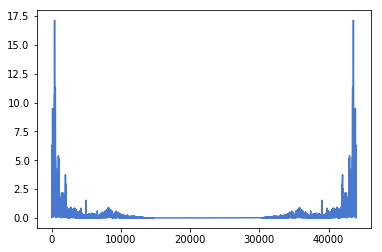

In [9]:
def get_fft(filename):
    y,sr = librosa.load(filename)
    fft = scipy.fft(y)
    print("Finished "+filename)
    return np.absolute(fft)
    

test_file = 'data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script01_1/Ses02F_script01_1_F004.wav'
fft = get_fft(test_file)
plt.plot(fft)
fft.shape

In [ ]:
x_train = list(map(lambda x: get_fft(x),X_train['wav_path']))
x_test = list(map(lambda x: get_fft(x),X_test['wav_path']))
try:
    with open('pickles/fft.pickle','wb') as f:
        save = {
            'train_dataset' : x_train,
            'train_labels' : y_train,
            'test_dataset' : x_test,
            'test_labels' : y_test
        }
        pickle.dump(save,f,pickle.HIGHEST_PROTOCOL)
except Exception as e:
    print('Unable to save data to fft pickle: ', e)
# try:
#     with open('pickles/fft.pickle','rb') as f:
#         save = pickle.load(f)
#         x_train = save['train_dataset']
#         y_train = save['train_labels']
#         x_test = save['test_dataset']
#         y_test = save['test_labels']
#         del save
# except Exception as e:
#     print('Error at:', e)


Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro04/Ses04F_impro04_F011.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro02/Ses03M_impro02_F011.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro04/Ses02M_impro04_M003.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro02/Ses04M_impro02_M003.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro01/Ses01F_impro01_M003.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script03_2/Ses02M_script03_2_M001.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro07/Ses01M_impro07_F009.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro05/Ses05F_impro05_M001.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro06/Ses02F_impro06_M015.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro03/Ses04F_impro03_F052.wav
Finished data/IEMOCAP_fu

Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script03_1/Ses03F_script03_1_M011.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro07/Ses01F_impro07_M012.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro04/Ses03M_impro04_F015.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script03_1/Ses01M_script03_1_F038.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro07/Ses01F_impro07_M009.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script03_1/Ses03M_script03_1_F006.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro06/Ses05F_impro06_F014.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script01_3/Ses01F_script01_3_M022.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro03/Ses03F_impro03_M005.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro08/Ses04M_impro08_M017.wav
Finish

Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro07/Ses05F_impro07_M027.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro07/Ses01M_impro07_F024.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script02_2/Ses01M_script02_2_F011.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script01_1/Ses04M_script01_1_F022.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro05/Ses05F_impro05_M002.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro02/Ses04M_impro02_M009.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro02/Ses01F_impro02_F020.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script01_2/Ses01M_script01_2_F005.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script02_2/Ses02M_script02_2_F013.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script02_2/Ses02F_script02_2_F012.wav


Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro06/Ses04F_impro06_F001.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro07/Ses03M_impro07_M025.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script03_2/Ses03M_script03_2_F001.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script01_1/Ses01M_script01_1_M041.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script02_1/Ses03F_script02_1_F010.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro05/Ses04M_impro05_M021.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_script02_1/Ses05F_script02_1_M009.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro01/Ses03M_impro01_F017.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script02_2/Ses03F_script02_2_F036.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro05/Ses01M_impro05_M026.wav


Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro02/Ses01M_impro02_M020.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro07/Ses05F_impro07_M036.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro08b/Ses03M_impro08b_F006.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro03/Ses04F_impro03_M003.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro03/Ses03F_impro03_F024.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro04/Ses05F_impro04_F022.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro03/Ses02M_impro03_F004.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script01_3/Ses03F_script01_3_M026.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script03_2/Ses01M_script03_2_M042.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro07/Ses02F_impro07_F013.wav
Finished data/IE

Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro07/Ses05M_impro07_M025.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script03_2/Ses04M_script03_2_F002.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script01_1/Ses02M_script01_1_F023.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script01_1/Ses04M_script01_1_F033.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro02/Ses04M_impro02_F025.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro07/Ses02F_impro07_F029.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro02/Ses01M_impro02_M000.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro05/Ses01F_impro05_F024.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script03_2/Ses04F_script03_2_M000.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro01/Ses03M_impro01_F009.wav
Finish

Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro08/Ses04M_impro08_M021.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro08/Ses05F_impro08_M005.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro03/Ses04F_impro03_F050.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro01/Ses02F_impro01_F020.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script01_1/Ses04F_script01_1_M019.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script01_3/Ses01M_script01_3_M022.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro02/Ses05F_impro02_M031.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro06/Ses03M_impro06_M026.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_impro07/Ses04F_impro07_F008.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro07/Ses03F_impro07_M000.wav
Finished data/IEMO

Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script03_1/Ses01M_script03_1_M014.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro05/Ses04M_impro05_M043.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script03_2/Ses02F_script03_2_F016.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script01_3/Ses01M_script01_3_M033.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script01_3/Ses03F_script01_3_M036.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script03_2/Ses01M_script03_2_M039.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script02_1/Ses01F_script02_1_M026.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro08/Ses05M_impro08_M004.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script02_1/Ses01F_script02_1_F008.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro05b/Ses03M_impr

Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro02/Ses04M_impro02_F007.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script02_2/Ses02M_script02_2_F045.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro04/Ses03M_impro04_M026.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro03/Ses03M_impro03_M012.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script02_1/Ses03M_script02_1_M033.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04F_script01_2/Ses04F_script01_2_F019.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro01/Ses02F_impro01_F010.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_impro01/Ses02M_impro01_M012.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro04/Ses05F_impro04_M027.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script02_2/Ses01M_script02_2_M052.wav
Finish

Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script02_2/Ses05M_script02_2_F017.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script02_2/Ses02F_script02_2_M041.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script02_1/Ses01F_script02_1_F000.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_impro07/Ses05M_impro07_M032.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script03_2/Ses02M_script03_2_M042.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script01_1/Ses01M_script01_1_M023.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script02_2/Ses01F_script02_2_F009.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script01_1/Ses01F_script01_1_F040.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script01_1/Ses03M_script01_1_M027.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script03_2/Ses

Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro06/Ses04M_impro06_M014.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script03_2/Ses01F_script03_2_F029.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro07/Ses03F_impro07_F020.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro03/Ses05F_impro03_F029.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro08/Ses05F_impro08_F026.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script03_2/Ses02M_script03_2_M043.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script02_2/Ses03F_script02_2_M030.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script01_1/Ses02M_script01_1_F011.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_impro03/Ses04M_impro03_M026.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_impro05b/Ses03M_impro05b_F003.wav
Fini

Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro05/Ses05F_impro05_M036.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_script03_2/Ses01F_script03_2_F004.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro07/Ses02F_impro07_M034.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script03_2/Ses01M_script03_2_F023.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script02_1/Ses02M_script02_1_M004.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_impro05/Ses01M_impro05_F017.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05F_impro08/Ses05F_impro08_M006.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro02/Ses01F_impro02_F000.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script01_3/Ses03F_script01_3_M029.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script03_2/Ses05M_script03_2_M027.wav


Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script02_2/Ses03F_script02_2_M035.wav
Finished data/IEMOCAP_full_release/Session4/sentences/wav/Ses04M_script03_1/Ses04M_script03_1_F022.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_script03_2/Ses03F_script03_2_F039.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro02/Ses03F_impro02_F026.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro04/Ses01F_impro04_M017.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro06/Ses02F_impro06_M004.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script03_2/Ses01M_script03_2_F022.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script02_2/Ses02F_script02_2_F027.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script01_1b/Ses05M_script01_1b_F023.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script02_1/Ses05M_script

Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_impro07/Ses02F_impro07_M005.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script01_1/Ses02M_script01_1_F012.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03M_script01_3/Ses03M_script01_3_M036.wav
Finished data/IEMOCAP_full_release/Session1/sentences/wav/Ses01M_script02_2/Ses01M_script02_2_M041.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script02_2/Ses05M_script02_2_M026.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02M_script02_1/Ses02M_script02_1_M040.wav
Finished data/IEMOCAP_full_release/Session5/sentences/wav/Ses05M_script01_1b/Ses05M_script01_1b_M020.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro04/Ses03F_impro04_F026.wav
Finished data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script02_2/Ses02F_script02_2_M018.wav
Finished data/IEMOCAP_full_release/Session3/sentences/wav/Ses03F_impro02/Ses03F_imp

In [ ]:
ang_train = map_for_emotion(y_train,emotional_mapping,'ang')
ang_test = map_for_emotion(y_test,emotional_mapping,'ang')
sad_train = map_for_emotion(y_train,emotional_mapping,'sad')
sad_test = map_for_emotion(y_test,emotional_mapping,'sad')
exc_train = map_for_emotion(y_train,emotional_mapping,'exc')
exc_test = map_for_emotion(y_test,emotional_mapping,'exc')
neu_train = map_for_emotion(y_train,emotional_mapping,'neu')
neu_test = map_for_emotion(y_test,emotional_mapping,'neu')
fru_train = map_for_emotion(y_train,emotional_mapping,'fru')
fru_test = map_for_emotion(y_test,emotional_mapping,'fru')
hap_train = map_for_emotion(y_train,emotional_mapping,'hap')
hap_test = map_for_emotion(y_test,emotional_mapping,'hap')

In [ ]:
x_train = pd.DataFrame(x_train).fillna(0)
x_test = pd.DataFrame(x_test).fillna(0)
print(x_train.shape, x_test.shape)
if(x_train.shape[1] > x_test.shape[1]):
    diff = x_train.shape[1] - x_test.shape[1]
    for i in range(diff):
        x_test[x_test.shape[1] + i] = 0
else:
    diff = x_test.shape[1] - x_train.shape[1]
    for i in range(diff):
        x_train[x_train.shape[1] + i] = 0
print(x_train.shape, x_test.shape)

In [ ]:
emotions = {'Anger':[ang_train, ang_test],'Sadness':[sad_train, sad_test], 'Excitement': [exc_train, exc_test], 'Neutral':[neu_train, neu_test], 'Frustration':[fru_train, fru_test], 'Happiness':[hap_train, hap_test]}

## Models Comparison

In [ ]:
models_result = compare_models_x_emotions(x_train,x_test , emotions)

In [ ]:
models_result

In [ ]:
def get_stft(filename):
    y,sr = librosa.load(filename)
    Y = librosa.stft(y)
    return Y

test_file = 'data/IEMOCAP_full_release/Session2/sentences/wav/Ses02F_script01_1/Ses02F_script01_1_F004.wav'
stft = get_stft(test_file)
plt.plot(stft)
stft.shape

In [ ]:
x_train = list(map(lambda x: get_stft(x),X_train['wav_path']))
x_test = list(map(lambda x: get_stft(x),X_test['wav_path']))
try:
    with open('pickles/stft.pickle','wb') as f:
        save = {
            'train_dataset' : x_train,
            'train_labels' : y_train,
            'test_dataset' : x_test,
            'test_labels' : y_test
        }
        pickle.dump(save,f,pickle.HIGHEST_PROTOCOL)
except Exception as e:
    print('Unable to save data to stft pickle: ', e)
# try:
#     with open('pickles/stft .pickle','rb') as f:
#         save = pickle.load(f)
#         x_train = save['train_dataset']
#         y_train = save['train_labels']
#         x_test = save['test_dataset']
#         y_test = save['test_labels']
#         del save
# except Exception as e:
#     print('Error at:', e)


In [ ]:
ang_train = map_for_emotion(y_train,emotional_mapping,'ang')
ang_test = map_for_emotion(y_test,emotional_mapping,'ang')
sad_train = map_for_emotion(y_train,emotional_mapping,'sad')
sad_test = map_for_emotion(y_test,emotional_mapping,'sad')
exc_train = map_for_emotion(y_train,emotional_mapping,'exc')
exc_test = map_for_emotion(y_test,emotional_mapping,'exc')
neu_train = map_for_emotion(y_train,emotional_mapping,'neu')
neu_test = map_for_emotion(y_test,emotional_mapping,'neu')
fru_train = map_for_emotion(y_train,emotional_mapping,'fru')
fru_test = map_for_emotion(y_test,emotional_mapping,'fru')
hap_train = map_for_emotion(y_train,emotional_mapping,'hap')
hap_test = map_for_emotion(y_test,emotional_mapping,'hap')

In [ ]:
x_train = pd.DataFrame(x_train).fillna(0)
x_test = pd.DataFrame(x_test).fillna(0)
print(x_train.shape, x_test.shape)
if(x_train.shape[1] > x_test.shape[1]):
    diff = x_train.shape[1] - x_test.shape[1]
    for i in range(diff):
        x_test[x_test.shape[1] + i] = 0
else:
    diff = x_test.shape[1] - x_train.shape[1]
    for i in range(diff):
        x_train[x_train.shape[1] + i] = 0
print(x_train.shape, x_test.shape)

In [ ]:
emotions = {'Anger':[ang_train, ang_test],'Sadness':[sad_train, sad_test], 'Excitement': [exc_train, exc_test], 'Neutral':[neu_train, neu_test], 'Frustration':[fru_train, fru_test], 'Happiness':[hap_train, hap_test]}

## Models Comparison

In [ ]:
models_result = compare_models_x_emotions(x_train,x_test , emotions)

In [ ]:
models_result

In [ ]:
Y = librosa.stft(y)
Ymag = librosa.power_to_db(Y)
librosa.display.specshow(Ymag, sr=sr, x_axis='time', y_axis='log')

In [ ]:
ipd.Audio(data=y,rate=sr)

In [ ]:
onset_frames = librosa.onset.onset_detect(y, sr=sr)
print onset_frames

In [ ]:
onset_times = librosa.frames_to_time(onset_frames, sr=sr)
print onset_times

In [ ]:
onset_samples = librosa.frames_to_samples(onset_frames)
print onset_samples

In [ ]:
clicks = librosa.clicks(times=onset_times,length=len(y))

In [ ]:
ipd.Audio(y, rate=sr)

In [ ]:
frame_sz = int(0.200*sr)
segments = np.array([y[i:i+frame_sz] for i in onset_samples])

In [ ]:
def concatenate_segments(segments, sr=22050, pad_time = 0.300):
    padded_segments = [np.concatenate([segment,np.zeros(int(pad_time*sr))]) for segment in segments]
    return np.concatenate(padded_segments)

In [ ]:
concatenated_signal = concatenate_segments(segments,sr)

In [ ]:
ipd.Audio(concatenated_signal, rate=sr)

In [ ]:
zcrs = [sum(librosa.core.zero_crossings(segment)) for segment in segments]
print zcrs

In [ ]:
sum(librosa.core.zero_crossings(y))

In [ ]:
# get_word_segments(test_align)

In [ ]:
ind = np.argsort(zcrs)
print(ind)

In [ ]:
concatenated_signal = concatenate_segments(segments[ind],sr)

In [ ]:
ipd.Audio(concatenated_signal,rate=sr)

In [ ]:
rmse = [sum(librosa.feature.rmse(segment)) for segment in segments]